# Preprocessing

In [2]:
import json
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt

Define absolute path to data.

In [3]:
data_path = ABSOLUTE_PATH_TO_DATA
unzipped_path = data_path+"/unzipped/"

Unzip data.

In [ ]:
try:
    data_path = "C:/Users/Tim/Desktop/makeathon/data/Messungen_PANE"
    for f in os.listdir(data_path):
        with zipfile.ZipFile(data_path+"/"+f, 'r') as zip_ref:
            zip_ref.extractall(data_path+"/unzipped/")
except PermissionError:
    unzipped_path = data_path+"/unzipped/"
    os.remove(unzipped_path+"OpcUA_PANE_BZ___2022_05_23__09_05_31.json.zip")
    print("done")

Fix JSON formatting.

In [5]:
for file_ in os.listdir(unzipped_path):
    with open(unzipped_path+file_, "r") as fin:
        lines = fin.readlines()
    modified = []
    for line in lines:
        modified.append(line[:-1] + "," + line[-1:])
    modified[0] = "[" + modified[0]
    modified[-1] = modified[-2] + "]"
    modified[-1] = modified[-1][:-3] + modified[-1][-2:]
    with open(unzipped_path+file_, "w") as fout:
        fout.writelines(modified)

Read all JSON files and gather them in a list.

In [5]:
files_json = []
for file_ in os.listdir(unzipped_path):
    if ".json" in file_:
        with open(unzipped_path+file_) as fin:
            files_json.append(json.load(fin))

Select which columns to include in the reformatted data.

In [6]:
sensor_cols = ["distanceSensors[0].calcValueInMm", "distanceSensors[1].calcValueInMm", "distanceSensors[2].calcValueInMm",
               "quadroSensorsAutoCommands[0].setpointInMm", "quadroSensorsAutoCommands[1].setpointInMm",
               "quadroSensorsAutoCommands[2].setpointInMm", "fConverters[3].rpdo.setpointPercentOfRpm",
               "fConverters[3].speed.actualMillimeterPerSecond", "fConverters[4].rpdo.setpointPercentOfRpm",
               ".fConverters[4].speed.actualMillimeterPerSecond", "safetyIOs.image.i11", "safetyIOs.image.i12",
               "safetyIOs.image.i15", "safetyIOs.image.iq2", "safetyIOs.image.iq3",
               "fConverters[2].rpdo.setpointPercentOfRpm", "fConverters[2].speed.actualMillimeterPerSecond",
               "fConverters[2].currentCurrent", "fConverters[2].nodeStatus", "fConverters[3].currentCurrent",
               "fConverters[3].nodeStatus", "fConverters[4].currentCurrent", "fConverters[4].nodeStatus"]

Reformat the data.

In [19]:
clean_file_names = [x[:-5] for x in os.listdir(unzipped_path) if ".json" in x]
for i, file in enumerate(files_json):
    col_data = {col:[] for col in sensor_cols}  # make dict to hold values for each col
    for row in file:
        node_id = row["addressSpaceItems"][0]["nodeId"]
        payload = row["payload"]
        
        if payload["statusCode"]["value"] != 0:
            # sensor error in this row
            continue
        
        timestamp = payload["sourceTimestamp"]
        value = payload["value"]["value"]
        
        for col in sensor_cols:
            if col in node_id:
                col_data[col].append([value, timestamp])
    
    # ignore file if empty
    empty = False
    for col in col_data.keys():
        if len(col_data[col]) == 0:
            empty = True
            
    if not empty:
        for col in sensor_cols:
            df_col = pd.DataFrame(col_data[col])
            dt = pd.to_datetime(df_col.iloc[:, 1], infer_datetime_format=True)
            sensor_dt = pd.Series(data=list(df_col.iloc[:, 0]), index=list(dt))
            sensor_resampled = sensor_dt.resample("1000ms").mean().interpolate()
            col_data[col] = sensor_resampled

        file_df = pd.DataFrame(data=col_data)
        
        for col in sensor_cols:
            if col_data[col].shape[0] == 1:
                # only one observation given, assume constant
                file_df[col] = col_data[col].iloc[0]
                
        # as stated by WP, incomplete timeseries should be assumed to be constant till the end
        file_df = file_df.interpolate(method="pad", limit_direction="forward")
        file_df.to_csv(data_path+"/csv/"+clean_file_names[i]+".csv")  # save as csv

Load example csv file and plot data as a test.

In [20]:
df = pd.read_csv(data_path+"/csv/OpcUA_PANE_BZ___2022_05_25__09_44_06.csv", index_col=0)
df.index = pd.to_datetime(df.index, infer_datetime_format=True)
df

,distanceSensors[0].calcValueInMm,distanceSensors[1].calcValueInMm,distanceSensors[2].calcValueInMm,quadroSensorsAutoCommands[0].setpointInMm,quadroSensorsAutoCommands[1].setpointInMm,quadroSensorsAutoCommands[2].setpointInMm,fConverters[3].rpdo.setpointPercentOfRpm,fConverters[3].speed.actualMillimeterPerSecond,fConverters[4].rpdo.setpointPercentOfRpm,.fConverters[4].speed.actualMillimeterPerSecond,...,safetyIOs.image.iq2,safetyIOs.image.iq3,fConverters[2].rpdo.setpointPercentOfRpm,fConverters[2].speed.actualMillimeterPerSecond,fConverters[2].currentCurrent,fConverters[2].nodeStatus,fConverters[3].currentCurrent,fConverters[3].nodeStatus,fConverters[4].currentCurrent,fConverters[4].nodeStatus
2022-05-25 07:42:13+00:00,101.585693,195.351257,33.785400,190.0,250.000000,180.0,819.000000,8.666667,819.0,0.000000,...,1.0,1.0,6894.000000,50.000000,22912.0,5.000000,96.500000,5.0,101.333333,4.5
2022-05-25 07:42:14+00:00,102.183838,194.208374,35.694444,190.0,249.951923,180.0,842.314286,0.000000,825.5,9.833333,...,1.0,1.0,6513.777778,47.203704,22848.0,4.998883,97.916667,5.0,125.666667,4.5
2022-05-25 07:42:15+00:00,110.429688,184.488525,37.603488,190.0,249.903846,180.0,865.628571,8.666667,832.0,9.599206,...,1.0,1.0,6133.555556,44.407408,22784.0,4.997765,99.333333,5.0,150.000000,4.5
2022-05-25 07:42:16+00:00,105.494995,184.232178,39.512533,190.0,249.855769,180.0,888.942857,8.253969,825.5,9.365079,...,1.0,1.0,5753.333333,41.611111,22720.0,4.996648,100.750000,5.0,151.000000,4.5
2022-05-25 07:42:17+00:00,109.062500,193.097534,41.421577,190.0,249.807692,180.0,912.257143,7.841270,819.0,9.130952,...,1.0,1.0,5373.111111,38.814815,22656.0,4.995531,102.166667,5.0,152.000000,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-25 07:58:42+00:00,113.847656,193.588867,33.785400,190.0,230.000000,180.0,944.000000,10.166667,1163.0,14.166667,...,1.0,1.0,0.000000,0.000000,0.0,4.000000,98.000000,5.0,152.000000,4.5
2022-05-25 07:58:43+00:00,113.206787,199.719849,33.785400,190.0,230.000000,180.0,944.000000,10.166667,1163.0,14.166667,...,1.0,1.0,0.000000,0.000000,0.0,4.000000,98.000000,5.0,151.666667,4.5
2022-05-25 07:58:44+00:00,112.181396,196.066895,33.785400,190.0,230.000000,180.0,944.000000,10.166667,1163.0,14.166667,...,1.0,1.0,0.000000,0.000000,0.0,4.000000,98.000000,5.0,151.333333,4.5
2022-05-25 07:58:45+00:00,112.459106,200.275269,33.785400,190.0,230.000000,180.0,944.000000,10.166667,1163.0,14.166667,...,1.0,1.0,0.000000,0.000000,0.0,4.000000,98.000000,5.0,151.000000,4.5


Durchlauf SOLL and IST.

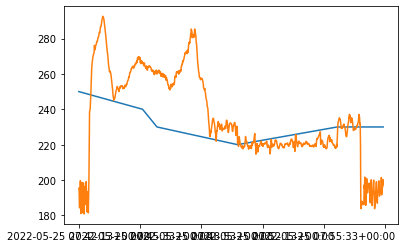

In [21]:
df["quadroSensorsAutoCommands[1].setpointInMm"].plot()
df["distanceSensors[1].calcValueInMm"].plot()
plt.show()

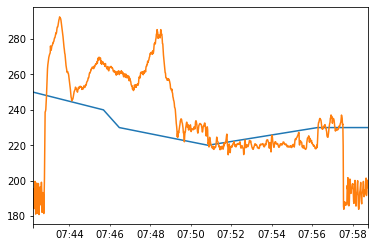

In [16]:
df["quadroSensorsAutoCommands[1].setpointInMm"].plot()
df["distanceSensors[1].calcValueInMm"].plot()
plt.show()

Input

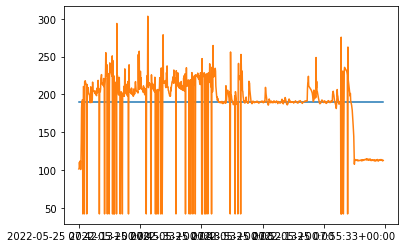

In [65]:
df["quadroSensorsAutoCommands[0].setpointInMm"].plot()
df["distanceSensors[0].calcValueInMm"].plot()
plt.show()

Out

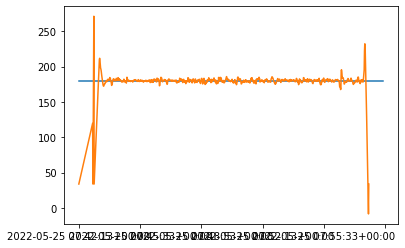

In [66]:
df["quadroSensorsAutoCommands[2].setpointInMm"].plot()
df["distanceSensors[2].calcValueInMm"].plot()
plt.show()